CASA0018 V2



## Import dependencies

In [76]:
%tensorflow_version 2.x

In [77]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.8.0

In [78]:


import os
import zipfile
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import math
import tensorflow_addons as tfa




from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Load Tensorflow Dataset

Load Tensorflow dataset - rock_paper_scissors

In [79]:
DATASET_NAME = 'rock_paper_scissors'

# Load dataset
dataset, info = tfds.load(DATASET_NAME, as_supervised=True, with_info=True)

dataset info

In [80]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

Check dataset labels

In [81]:
# Check dataset labels
num_classes = info.features["label"].num_classes  # number of classes
get_class_name = info.features["label"].int2str      # class names

print(num_classes)        # 3
print(get_class_name(0)); # rock
print(get_class_name(1)); # paper
print(get_class_name(2)); # scissors


3
rock
paper
scissors


Slice the dataset to three sets (Train, validation and test).
Number of images:
  Train set: 2142
  Valid set: 372
  Test set: 378

In [82]:
train_set_raw, valid_set_raw, test_set_raw = tfds.load(DATASET_NAME, 
                                           split=["train[:85%]", "train[85%:]", "test"],
                                           as_supervised=True)
TRAIN_SIZE = len(train_set_raw)
VALID_SIZE = len(valid_set_raw)
TEST_SIZE = len(test_set_raw)

print("Train set size: ", TRAIN_SIZE)   # Train set size:  2142
print("Valid set size: ", VALID_SIZE)   # Valid set size:  378
print("Test set size: ", TEST_SIZE)     # Test set size:  372

Train set size:  2142
Valid set size:  378
Test set size:  372


## Explore the Dataset

Preview the dataset

In [83]:
# define dataset preview
def preview_dataset(dataset):
    plt.figure(figsize=(12, 8))
    plot_index = 0
    for features in dataset.take(8):
        (image, label) = features
        plot_index += 1
        plt.subplot(2, 4, plot_index)
        # plt.axis('Off')
        label = get_class_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

Preview the train set

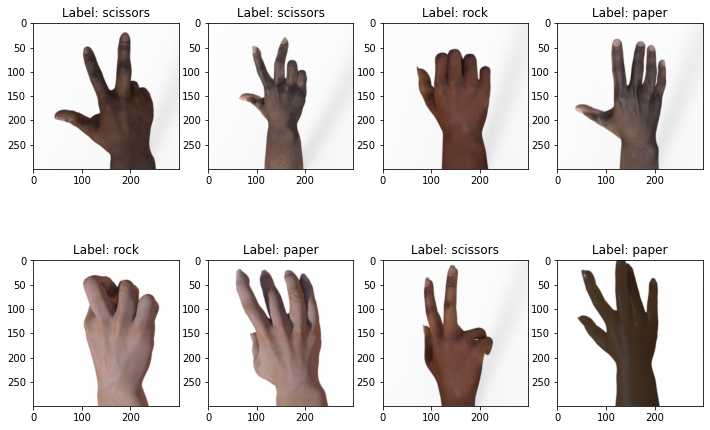

In [84]:
preview_dataset(train_set_raw)

Preview the validation set

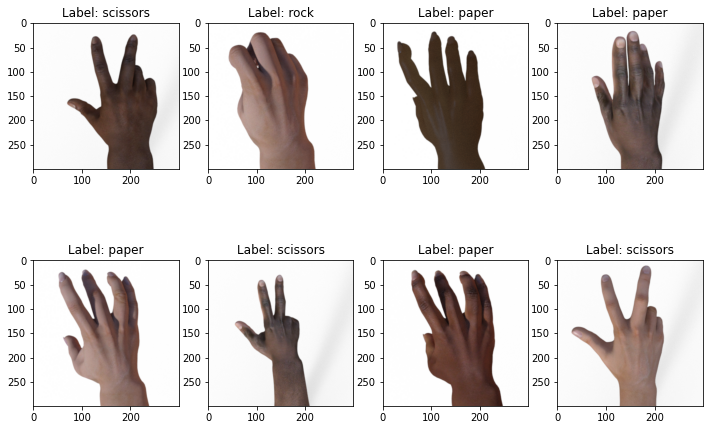

In [85]:
preview_dataset(valid_set_raw)

Preview the test set

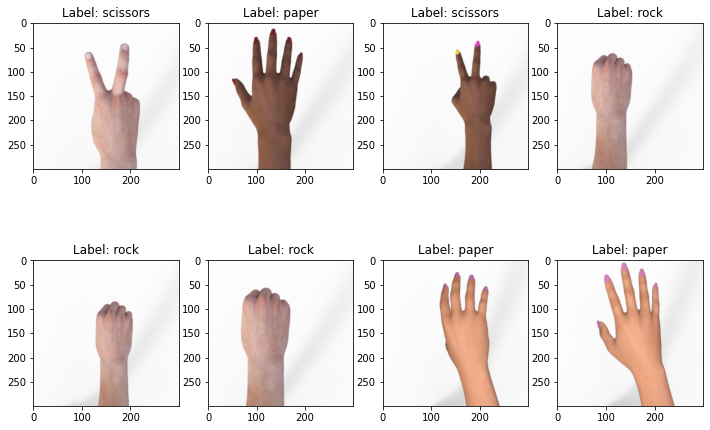

In [86]:
preview_dataset(test_set_raw)

Explore the image format

In [87]:
# Explore the image format
(image_sample, image_label) = list(train_set_raw.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Pre-processing the dataset

#### Image Resize

Set expected image size

In [88]:
IMG_SIZE_ORG = info.features['image'].shape[0]
IMG_SHAPE_ORG = info.features['image'].shape

IMG_SIZE_MOD = IMG_SIZE_ORG // 2
IMG_SHAPE_MOD = (IMG_SIZE_MOD, IMG_SIZE_MOD, IMG_SHAPE_ORG[2])

# Here we may switch between bigger or smaller image sized that we will train our model on.
IMG_SIZE = IMG_SIZE_MOD
IMG_SHAPE = IMG_SHAPE_MOD

print('Original image size:', IMG_SIZE_ORG)
print('Original image shape:', IMG_SHAPE_ORG)
print('Reduced image size:', IMG_SIZE_MOD)
print('Reduced image shape:', IMG_SHAPE_MOD)
print('Image size:', IMG_SIZE)
print('Image shape:', IMG_SHAPE)

Original image size: 300
Original image shape: (300, 300, 3)
Reduced image size: 150
Reduced image shape: (150, 150, 3)
Image size: 150
Image shape: (150, 150, 3)


Reduce the image size

In [89]:
def resize_image(img, label):
  img = tf.cast(img, tf.float32) # set color values to float
  img = img / 255.               # map color values to the range [0 1]
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  return img, label

In [90]:
train_set_resize = train_set_raw.map(resize_image)
valid_set_resize = valid_set_raw.map(resize_image)
test_set_resize = test_set_raw.map(resize_image)


Check the image format after the size reduced

In [91]:
# Check the image format
(image_sample, image_label) = list(train_set_resize.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

Check the dataset preview 

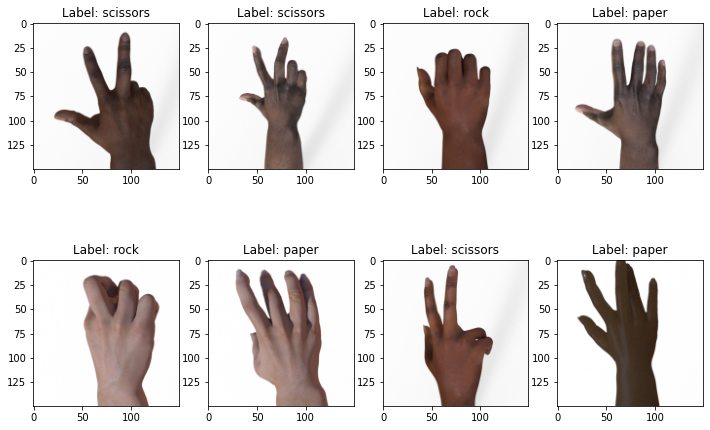

In [92]:
preview_dataset(train_set_resize)

#### Image Transform

define transformation

In [93]:
# colour
def random_img_colour(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.random_brightness(img, 0.06)
  img = tf.image.random_hue(img, max_delta=0.06)
  img = tf.image.random_saturation(img, lower=0.6, upper=1.4)
  img = tf.image.random_contrast(img, lower=0.75, upper=1)
  img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=1)
  return img

# rotation (0/90/180/270 degrees) 
def random_img_rotate(img: tf.Tensor) -> tf.Tensor:
  # Rotate 0, 90, 180, 270 degrees
  return tf.image.rot90(
    img,
    tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
  )

  

# flip up, down, left and right
def random_img_flip(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  return img

# zoom
def random_img_zoom(img: tf.Tensor, zoom_min=0.8, zoom_max=1.0) -> tf.Tensor:
  img_width, img_height, img_colours = img.shape
  crop_size = (img_width, img_height)

  # crop range 1% to 20%
  scales = list(np.arange(zoom_min, zoom_max, 0.01))
  boxes = np.zeros((len(scales), 4))

  for i, scale in enumerate(scales):
    x1 = y1 = 0.5 - (0.5 * scale)
    x2 = y2 = 0.5 + (0.5 * scale)
    boxes[i] = [x1, y1, x2, y2]

  def img_crop(img):
    # crop parameters
    crops = tf.image.crop_and_resize(
      [img],
      boxes=boxes,
      box_indices=np.zeros(len(scales)),
      crop_size=crop_size
    )
    # random crop
    return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

  # set 50% propability to apply crop
  choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
  return tf.cond(choice < 0.5, lambda: img, lambda: img_crop(img))

# colour inversion
def random_img_inversion(img: tf.Tensor) -> tf.Tensor:
  random = tf.random.uniform(shape=[], minval=0, maxval=1)
  if random > 0.5:
    img = tf.math.multiply(img, -1)
    img = tf.math.add(img, 1)
  return img

# ----- GRAYSCALE ---------------------------------
def img_to_grayscale(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.rgb_to_grayscale(img)
  return img
# ----- GRAYSCALE ---------------------------------

# apply random image transform
def image_transform(img,label):
  img = random_img_colour(img)
  img = random_img_inversion(img)
  img = random_img_zoom(img)
  img = random_img_flip(img)
  img = random_img_rotate(img)
# ----- GRAYSCALE ---------------------------------
  img = img_to_grayscale(img)
# ----- GRAYSCALE ---------------------------------  
  return img, label



Implement transformation to train, validationa and test sets

In [94]:
train_set_transformed = train_set_resize.map(image_transform)
valid_set_transformed = valid_set_resize.map(image_transform)
test_set_transformed = test_set_resize.map(image_transform)

In [95]:
# Check the image format
(image_sample, image_label) = list(train_set_transformed.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())



Label: 2 

Image shape: (150, 150, 1) 

[[[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 ...

 [[8.9700057e-05]
  [4.6185282e-04]
  [2.6093307e-03]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[2.0831305e-04]
  [2.1488895e-04]
  [1.8123819e-03]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[4.9212843e-04]
  [1.3511978e-03]
  [4.0874080e-04]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]]


Check dataset after transformed

In [96]:
# ----- GRAYSCALE ---------------------------------

# define dataset preview
def preview_dataset_grayscale(dataset):
  plt.figure(figsize=(12, 8))
  plot_index = 0
  for features in dataset.take(8):
    (image, label) = features
    plot_index += 1
    plt.subplot(2, 4, plot_index)
    label = get_class_name(label.numpy())
    plt.title('Label: %s' % label)
    plt.imshow(image.numpy()[:,:,0],cmap='gray')

# ----- GRAYSCALE ---------------------------------


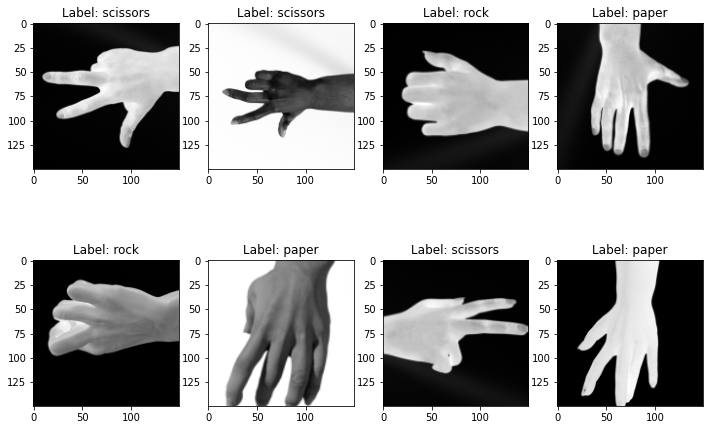

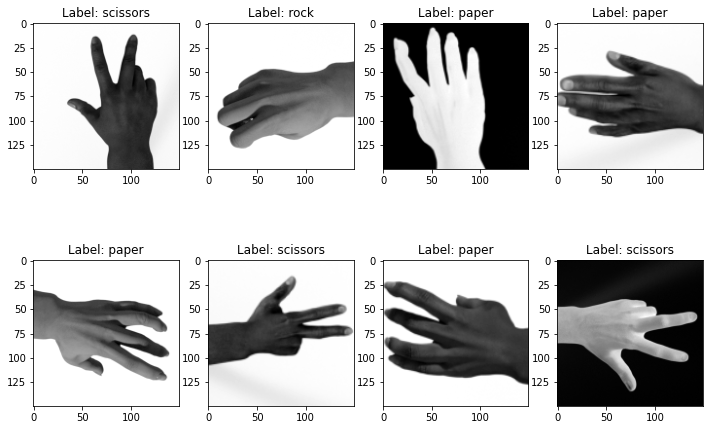

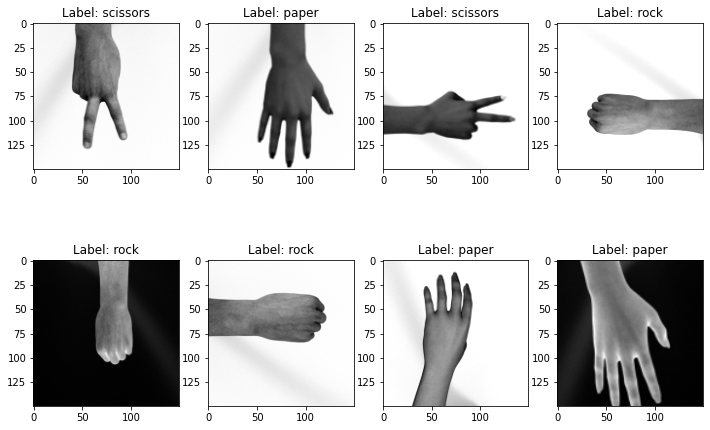

In [97]:
# preview_dataset(train_set_transformed)
# preview_dataset(valid_set_transformed)
# preview_dataset(test_set_transformed)

# ----- GRAYSCALE ---------------------------------
preview_dataset_grayscale(train_set_transformed)
preview_dataset_grayscale(valid_set_transformed)
preview_dataset_grayscale(test_set_transformed)

#### Shuffling and batching

In [98]:
BATCH_SIZE = 32

train_set_shuffled = train_set_transformed.shuffle(
    buffer_size=TRAIN_SIZE
)

train_set_shuffled = train_set_transformed.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
train_set_shuffled = train_set_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)


# valid_set_shuffled = valid_set_resize.batch(BATCH_SIZE)
valid_set_shuffled = valid_set_transformed.batch(BATCH_SIZE)

test_set_shuffled = test_set_transformed.batch(BATCH_SIZE)


print(train_set_shuffled)
print(valid_set_shuffled)
print(test_set_shuffled)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 1) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.9354092 ]
  [0.935838  ]
  [0.9366516 ]
  ...
  [0.94170165]
  [0.94169533]
  [0.941254  ]]

 [[0.9358365 ]
  [0.9363631 ]
  [0.93618876]
  ...
  [0.9410857 ]
  [0.9416169 ]
  [0.94155896]]

 [[0.9357509 ]
  [0.9359585 ]
  [0.93510866]
  ...
  [0.9403717 ]
  [0.9414489 ]
  [0.9416198 ]]

 ...

 [[0.9212164 ]
  [0.9224041 ]
  [0.9228352 ]
  ...
  [0.93444556]
  [0.93418425]
  [0.93388766]]

 [[0.9214701 ]
  [0.92261326]
  [0.9225198 ]
  ...
  [0.9337356 ]
  [0.93415576]
  [0.93427235]]

 [[0.92142457]
  [0.92265385]
  [0.9216438 ]
  ...
  [0.93248993]
  [0.9327382 ]
  [0.933392  ]]] 



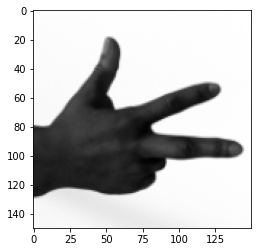

In [100]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(train_set_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
# ---------------------------------------- GRAYSCALE ---------------------------------       
        plt.imshow(image_batch[batch_item_index][:,:,0],cmap='gray')
# ----------------------------------------- GRAYSCALE ---------------------------------
        # plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

## Build Model

In [101]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation = 'relu'),
#     tf.keras.layers.Dense(3, activation = 'softmax')
# ])



# ----- GRAYSCALE ---------------------------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])


# ----- GRAYSCALE ---------------------------------




# model.compile(
#     loss = 'categorical_crossentropy',
#     optimizer = tf.optimizers.Adam(),
#     metrics = ['accuracy']               
# )
# model.summary()


# model = tf.keras.models.Sequential()

# # First convolution.
# model.add(tf.keras.layers.Convolution2D(
#     input_shape=IMG_SHAPE, filters=64,
#     kernel_size=3,
#     activation=tf.keras.activations.relu
# ))
# model.add(tf.keras.layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=(2, 2)
# ))

# # Second convolution.
# model.add(tf.keras.layers.Convolution2D(
#     filters=64,
#     kernel_size=3,
#     activation=tf.keras.activations.relu
# ))
# model.add(tf.keras.layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=(2, 2)
# ))

# # Third convolution.
# model.add(tf.keras.layers.Convolution2D(
#     filters=128,
#     kernel_size=3,
#     activation=tf.keras.activations.relu
# ))
# model.add(tf.keras.layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=(2, 2)
# ))

# # Fourth convolution.
# model.add(tf.keras.layers.Convolution2D(
#     filters=128,
#     kernel_size=3,
#     activation=tf.keras.activations.relu
# ))
# model.add(tf.keras.layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=(2, 2)
# ))

# # Flatten the results to feed into dense layers.
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.5))

# # 512 neuron dense layer.
# model.add(tf.keras.layers.Dense(
#     units=512,
#     activation=tf.keras.activations.relu
# ))

# # Output layer.
# model.add(tf.keras.layers.Dense(
#     units=num_classes,
#     activation=tf.keras.activations.softmax
# ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

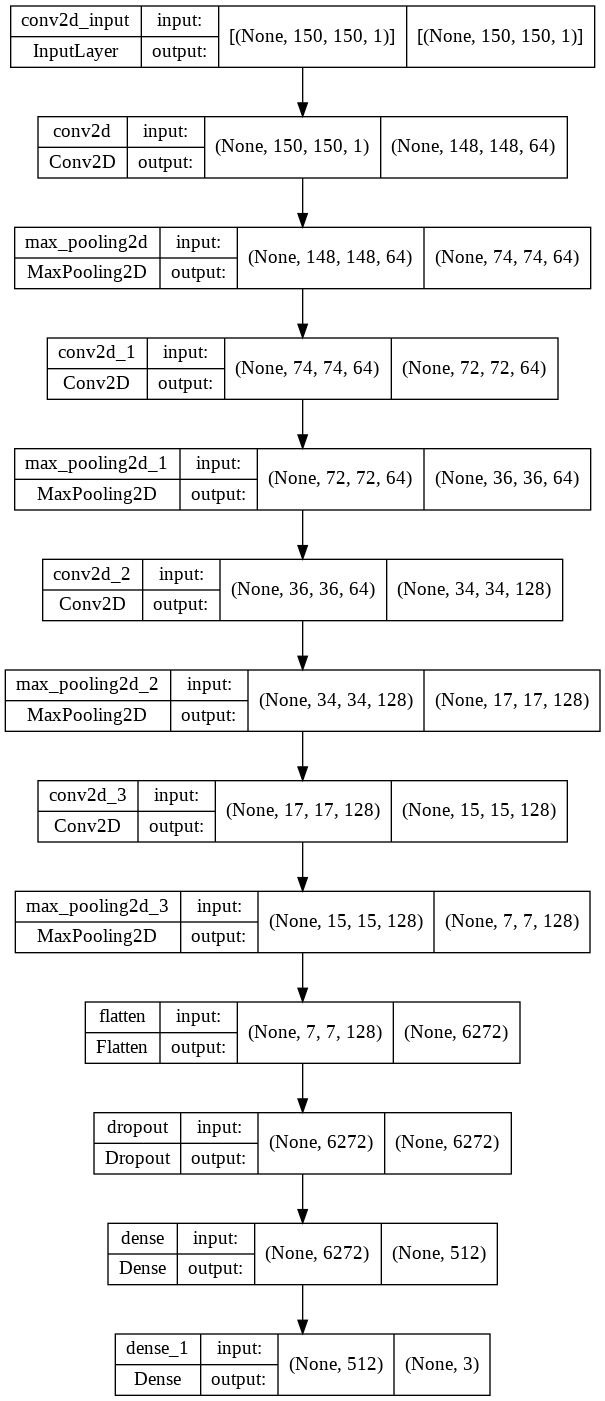

In [102]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [103]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [104]:
steps_per_epoch = TRAIN_SIZE // BATCH_SIZE
validation_steps = VALID_SIZE // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

!rm -rf tmp/checkpoints
!rm -rf logs

# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

steps_per_epoch: 66
validation_steps: 11


In [105]:
training_history = model.fit(
    x=train_set_shuffled.repeat(),
    validation_data=valid_set_shuffled.repeat(),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/10
66/66 [==============================] - 33s 337ms/step - loss: 1.1408 - accuracy: 0.4134 - val_loss: 1.1264 - val_accuracy: 0.5114
Epoch 2/10
66/66 [==============================] - 29s 428ms/step - loss: 0.7772 - accuracy: 0.6929 - val_loss: 1.3156 - val_accuracy: 0.5625
Epoch 3/10
66/66 [==============================] - 29s 441ms/step - loss: 0.4750 - accuracy: 0.8289 - val_loss: 0.2935 - val_accuracy: 0.9062
Epoch 4/10
66/66 [==============================] - 20s 311ms/step - loss: 0.3033 - accuracy: 0.8882 - val_loss: 0.2836 - val_accuracy: 0.8892
Epoch 5/10
66/66 [==============================] - 20s 305ms/step - loss: 0.2369 - accuracy: 0.9275 - val_loss: 0.1558 - val_accuracy: 0.9602
Epoch 6/10
66/66 [==============================] - 20s 313ms/step - loss: 0.1785 - accuracy: 0.9431 - val_loss: 0.1232 - val_accuracy: 0.9688
Epoch 7/10
66/66 [==============================] - 20s 312ms/step - loss: 0.1322 - accuracy: 0.9488 - val_loss: 0.1300 - val_accuracy: 0.9602

In [106]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

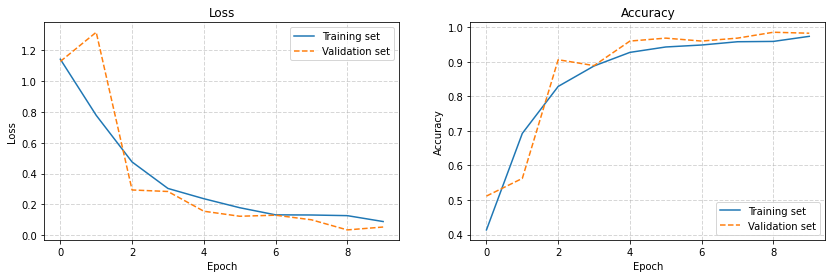

In [107]:
render_training_history(training_history)

In [108]:
test_loss, test_accuracy = model.evaluate(test_set_shuffled)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

12/12 [==============================] - 3s 250ms/step - loss: 0.2888 - accuracy: 0.8925
Test loss:  0.28876253962516785
Test accuracy:  0.8924731016159058


Saving paper101.jpg to paper101 (1).jpg
Saving paper102.jpg to paper102 (1).jpg
Saving paper103.jpg to paper103 (1).jpg
Saving paper104.jpg to paper104 (1).jpg
Saving paper105.jpg to paper105 (2).jpg
Saving paper106.jpg to paper106 (2).jpg
Saving paper107.jpg to paper107 (2).jpg
Saving paper108.jpg to paper108 (2).jpg
Saving rock101.jpg to rock101 (1).jpg
Saving rock102.jpg to rock102 (1).jpg
Saving rock103.jpg to rock103 (1).jpg
Saving rock104.jpg to rock104 (1).jpg
Saving rock105.jpg to rock105 (1).jpg
Saving rock106.jpg to rock106 (1).jpg
Saving rock107.jpg to rock107 (1).jpg
Saving rock108.jpg to rock108 (1).jpg
Saving scissors101.jpg to scissors101 (2).jpg
Saving scissors102.jpg to scissors102 (1).jpg
Saving scissors103.jpg to scissors103 (1).jpg
Saving scissors104.jpg to scissors104 (1).jpg
Saving scissors105.jpg to scissors105 (1).jpg
Saving scissors106.jpg to scissors106 (1).jpg
Saving scissors107.jpg to scissors107 (1).jpg
Saving scissors108.jpg to scissors108 (1).jpg
paper101

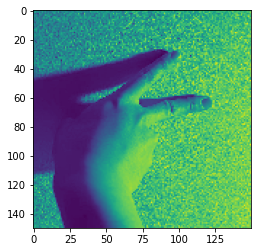

In [122]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  # img_source = image.load_img(path, target_size = (150, 150))
  img_source = image.load_img(path, color_mode = "grayscale", target_size = (150, 150))

  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes[0, 0] == 1:
    print('rock')
  elif classes[0, 1] == 1:
    print('paper')
  elif classes[0, 2] == 1:
    print('scissors')